In [ ]:
# 1. Разведка

In [ ]:
! kaggle competitions download -c hse-intro-ds-2022-hw1

import zipfile
z = zipfile.ZipFile('hse-intro-ds-2022-hw1.zip', 'r')
z.extract('train.csv')
z.extract('test.csv')
z.extract('sample_submission.csv')
z.close()

# BadZipFile: File is not a zip file
# распаковать не получилось, загружаю трейн и тест вручную

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


BadZipFile: ignored

In [87]:
import numpy as np
import pandas as pd
import re

!pwd
!ls

/content
sample_data  train.csv


In [88]:
# здесь также определяем, что считать пропуском -
# и определяем как NaN значения (самые на первый взгляд заметные и частые)

data = pd.read_csv("train.csv", encoding="utf-8", on_bad_lines='skip', 
                   na_values = {
                                "target": ["NaN"],
                                "surname": ["NaN", "-", "*", "---", "."],
                                "name": ["NaN", "-", "*", "---", "."],
                                "patronymic": ["NaN", "-", "*", "---", "."]})
#data.head(263)

,Id,surname,name,patronymic,target
0,2636471,ЯКУШОВА,ЕЛЕНА,СЕРГЕЕВНА,0.0
1,165386,ВАБИЩЕВИЧ,ФЕДОР,ПЕТРОВИЧ,1.0
2,243807,ГОЛУБЕВА,ОЛЬГА,АНТОНОВНА,0.0
3,232582,ГЛАЗКОВ,АНДРЕЙ,ВЛАДИМИРОВИЧ,1.0
4,3970023,ГАВРИЩУК,МАРК,ВАДИМОВИЧ,1.0
...,...,...,...,...,...
258,4803552,МАКСИМОВ,ОЛЕГ,ВЛАДИМИРОВИЧ,1.0
259,4697267,ЗУЙКОВА,ЛЮБОВЬ,ИЛЬИНИЧНА,0.0
260,6038052,МАМАЛИГА,САВА,NaN,1.0
261,4215560,ИВАНОВА,ОЛЬГА,ВЛАДИМИРОВНА,0.0


In [89]:
#data.shape

(5917177, 5)

In [44]:
males = data.loc[data['target'] == 1.0]
females = data.loc[data['target'] == 0.0]

In [ ]:
# Задание 1.1

In [ ]:
# общий обзор

data.describe(include='all')

,Id,surname,name,patronymic,target
count,5.917177e+06,5917094,5917032,5900432,5.917169e+06
unique,NaN,375149,43832,78389,NaN
top,NaN,ИВАНОВА,АЛЕКСАНДР,АЛЕКСАНДРОВНА,NaN
freq,NaN,23079,257696,295265,NaN
mean,3.114239e+06,NaN,NaN,NaN,4.372273e-01
std,1.798065e+06,NaN,NaN,NaN,4.960440e-01
min,0.000000e+00,NaN,NaN,NaN,0.000000e+00
25%,1.556910e+06,NaN,NaN,NaN,0.000000e+00
50%,3.114242e+06,NaN,NaN,NaN,0.000000e+00
75%,4.671429e+06,NaN,NaN,NaN,1.000000e+00


In [ ]:
# место и количество пропущенных данных

print(pd.isnull(data).sum())

Id                0
surname          83
name            145
patronymic    16745
target            8
dtype: int64


In [ ]:
# пропуски в графах фамилия (83), имя (145), отчество (16745) и пол (8)
# заполнить можно только пол, 
# остальные строки с отсутствующими данными удалить

In [ ]:
# вот так можно заполнить пол, где он пропущен

if str(data['patronymic'])[-1] == "А": 
    data['target'].fillna(0.0, inplace=True)
else:
    data['target'].fillna(1.0, inplace=True)

In [ ]:
# понимаем, что он пропущен не у людей, поэтому ничего не заполняем, потом удалим

data[data['target'].isnull()]

,Id,surname,name,patronymic,target
749245,1665280,1900304,МАЛАХОВКА,УЛ.КАЛИНИ,NaN
755005,1654031,ЗАО ПРЕДПРИЯТИЕ ИТИ,ПО ПОСТ.ИНФ.,ТЕХНО,NaN
2254715,1752987,УПРАВЛЕНИЕ ПО ДЕЛАМ,МОЛОДЕЖИ,КУЛЬТУРЫ,NaN
2551660,1654029,АООТЭЛЕКТРОСВЯЗЬ,О,/З-Й УЗЕЛ ЭЛЕКТРОСВЯ,NaN
3313534,1665290,1900163,ЛЮБЕРЦЫ,УЛ.ЮЖНАЯ,NaN
5341561,1656255,КОМИТЕТ ПО ФИЗИЧЕСКО,Й КУЛЬТУРЕ,СПОРТУ,NaN
5476144,1654030,ЗАО ПРЕДПРИЯТИЕ ИТИ,ПО ПОСТ.ИНФ.,ТЕХНО,NaN
5600867,1650995,УПРАВЛЕНИЕ ПО ДЕЛАМ,МОЛОДЕЖИ,КУЛЬТУРЫ,NaN


In [90]:
# удаляем все строки с пропусками (имя, фамилию и отчество невозможно восстановить)
# можно, конечно, заполнить самыми распространенными, но поскольку процент пропусков небольшой, лучше удалить
# искать дубликаты и заполнять оттуда тоже бессмысленно, мы их все равно потом удалим

data.dropna(axis=0,inplace=True)

#data.head(263)

,Id,surname,name,patronymic,target
0,2636471,ЯКУШОВА,ЕЛЕНА,СЕРГЕЕВНА,0.0
1,165386,ВАБИЩЕВИЧ,ФЕДОР,ПЕТРОВИЧ,1.0
2,243807,ГОЛУБЕВА,ОЛЬГА,АНТОНОВНА,0.0
3,232582,ГЛАЗКОВ,АНДРЕЙ,ВЛАДИМИРОВИЧ,1.0
4,3970023,ГАВРИЩУК,МАРК,ВАДИМОВИЧ,1.0
...,...,...,...,...,...
258,4803552,МАКСИМОВ,ОЛЕГ,ВЛАДИМИРОВИЧ,1.0
259,4697267,ЗУЙКОВА,ЛЮБОВЬ,ИЛЬИНИЧНА,0.0
261,4215560,ИВАНОВА,ОЛЬГА,ВЛАДИМИРОВНА,0.0
262,43704,АНТИПОВА,ЛАРИСА,АЛЕКСЕЕВНА,0.0


In [ ]:
#data.shape

(5900207, 5)

In [ ]:
# Вывод: пропущенные фамилию, имя и отчество корректно заполнить невозможно
# (заполнение самыми распространенными значениями даст погрешность не меньше, чем удаление)
# самый частый пропуск - отчество, которого у человека может не быть
# про пол см выше
# можно, в принципе, заполнить пропуски в отчестве значением "-1" или
# самым частым значением для этого пола, но поскольку процент небольшой
# (17 тыс из 5,9 млн), то проще удалить

In [ ]:
# Задание 1.2

In [ ]:
# строки со вторым и более вхождением дубликата

data[data.duplicated(subset=['surname', 'name', 'patronymic', 'target'], keep = 'first')]

,Id,surname,name,patronymic,target
1117,925229,РЫБАКОВА,АННА,НИКОЛАЕВНА,0.0
1567,380669,ЖУКОВА,ЛЮДМИЛА,АНАТОЛЬЕВНА,0.0
1863,429116,ИВАНОВА,ЛИДИЯ,НИКОЛАЕВНА,0.0
3036,5999348,ГАЛКИН,МИХАИЛ,ИВАНОВИЧ,1.0
3147,2736561,ТИТОВА,ВАЛЕНТИНА,НИКОЛАЕВНА,0.0
...,...,...,...,...,...
5917170,2955122,ЗОТОВА,ГАЛИНА,ВЛАДИМИРОВНА,0.0
5917172,1428135,ОРЛОВА,СВЕТЛАНА,АЛЕКСАНДРОВНА,0.0
5917174,3361959,ГРОШЕВ,ЕВГЕНИЙ,ЮРЬЕВИЧ,1.0
5917175,2065244,МАКАРОВА,НИНА,АЛЕКСЕЕВНА,0.0


In [ ]:
# количество дубликатов

data[data.duplicated(subset=['surname', 'name', 'patronymic', 'target'], keep = 'first')].shape

(1866247, 5)

In [91]:
# удаление дубликатов

data.drop_duplicates(subset=['surname', 'name', 'patronymic', 'target'], keep = 'first', inplace = True)

In [ ]:
#data.shape

(4033960, 5)

In [ ]:
# Дубликаты лучше удалять, поскольку при обучении на них компьютер не получает новой информации,
# зато приходится обрабатывать больше данных, это дольше и энергозатратнее
# Также это портит статистику с точки зрения разнообразия выборки

In [ ]:
# Задание 1.3

In [ ]:
# количество женщин и мужчин 

data[['target', 'Id']].groupby('target').count().reset_index()

,target,Id
0,0.0,2251340
1,1.0,1782621


In [ ]:
# для удобства графиков временно создадим столбец sex

gender = {0.0: "female", 1.0: "male"}
data['sex'] = data['target'].map(gender)

In [ ]:
#data.head()

,Id,surname,name,patronymic,target,sex
0,2636471,ЯКУШОВА,ЕЛЕНА,СЕРГЕЕВНА,0.0,female
1,165386,ВАБИЩЕВИЧ,ФЕДОР,ПЕТРОВИЧ,1.0,male
2,243807,ГОЛУБЕВА,ОЛЬГА,АНТОНОВНА,0.0,female
3,232582,ГЛАЗКОВ,АНДРЕЙ,ВЛАДИМИРОВИЧ,1.0,male
4,3970023,ГАВРИЩУК,МАРК,ВАДИМОВИЧ,1.0,male


In [ ]:
# дальше смотрим распределение по полу на разных графиках

In [48]:
import seaborn as sns

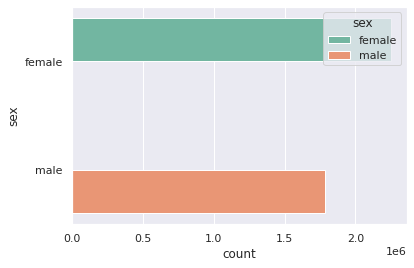

In [ ]:
sns.set_theme(style='darkgrid')
sns.countplot(y='sex', data=data, hue='sex', palette = "Set2")

In [47]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


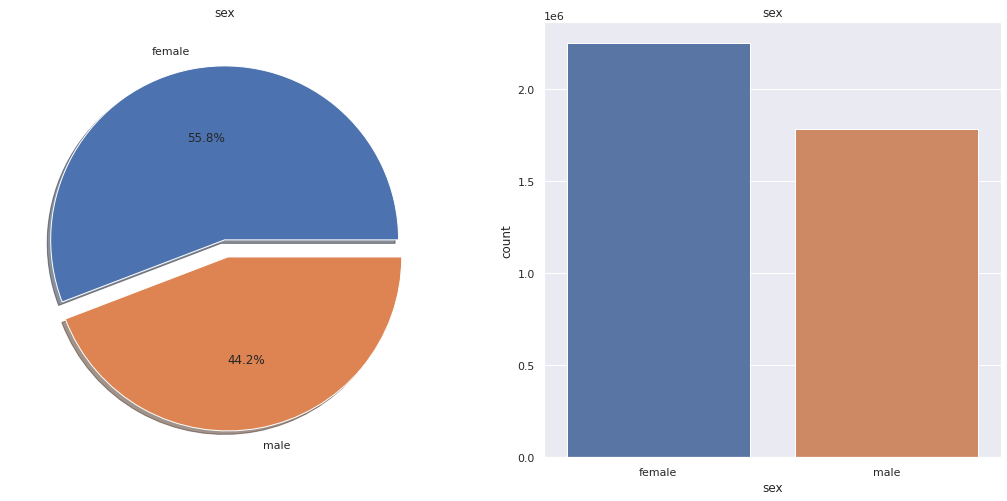

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
data['sex'].value_counts().plot.pie(explode=[0, 0.1], 
                                          autopct='%1.1f%%',
                                          ax=ax[0],
                                          shadow=True)

ax[0].set_title('sex')
ax[0].set_ylabel('')

sns.countplot('sex', data=data, ax=ax[1])
ax[1].set_title('sex')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


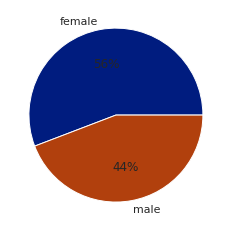

In [ ]:
staff = [data[['target', 'Id']].groupby('target').count()]
keys = ['female', 'male']

palette_color = sns.color_palette('dark')

plt.pie(staff, labels=keys, colors=palette_color, autopct='%.0f%%')
  
plt.show()

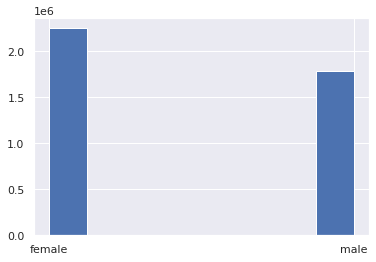

In [ ]:
data.sex.hist(bins=8)

In [ ]:
# удаляем столбец sex

data = data.drop(['sex'], axis = 1)

In [ ]:
# Задание 1.4

In [92]:
from pandas.core.algorithms import value_counts

In [72]:
males = data.loc[data['target'] == 1.0]
females = data.loc[data['target'] == 0.0]

In [ ]:
# топ 10 самых популярных имен у женщин

females.groupby('target')['name'].value_counts(ascending=False)[:10]

target  name     
0.0     ТАТЬЯНА      118054
        ЕЛЕНА        114055
        НАТАЛЬЯ       96135
        ОЛЬГА         95122
        АННА          86240
        МАРИЯ         83632
        ИРИНА         80385
        ВАЛЕНТИНА     80175
        СВЕТЛАНА      75540
        ГАЛИНА        73078
Name: name, dtype: int64

In [ ]:
# топ 10 самых популярных имен у мужчин

males.groupby('target')['name'].value_counts(ascending=False)[:10]

target  name     
1.0     АЛЕКСАНДР    138894
        СЕРГЕЙ       112067
        ВЛАДИМИР      99132
        АЛЕКСЕЙ       84260
        НИКОЛАЙ       76910
        АНДРЕЙ        67447
        ДМИТРИЙ       66052
        ВИКТОР        59914
        МИХАИЛ        58914
        ЮРИЙ          52675
Name: name, dtype: int64

In [ ]:
# топ 10 самых популярных фамилий у женщин

females.groupby('target')['surname'].value_counts(ascending=False)[:10]

target  surname  
0.0     ИВАНОВА      3820
        КУЗНЕЦОВА    3375
        СМИРНОВА     3060
        ПОПОВА       2594
        ВОЛКОВА      2548
        НОВИКОВА     2468
        КОЗЛОВА      2405
        ВАСИЛЬЕВА    2365
        ПЕТРОВА      2350
        МОРОЗОВА     2281
Name: surname, dtype: int64

In [ ]:
# топ 10 самых популярных фамилий у мужчин

males.groupby('target')['surname'].value_counts(ascending=False)[:10]

target  surname 
1.0     ИВАНОВ      2655
        КУЗНЕЦОВ    2281
        СМИРНОВ     2037
        ВОЛКОВ      1825
        ПОПОВ       1814
        ВАСИЛЬЕВ    1731
        НОВИКОВ     1725
        ПЕТРОВ      1694
        КОЗЛОВ      1676
        МОРОЗОВ     1562
Name: surname, dtype: int64

In [ ]:
# топ 10 самых популярных отчеств у женщин

females.groupby('target')['patronymic'].value_counts(ascending=False)[:10]

target  patronymic   
0.0     АЛЕКСАНДРОВНА    164888
        НИКОЛАЕВНА       142377
        ВЛАДИМИРОВНА     129946
        ИВАНОВНА         127553
        СЕРГЕЕВНА        117570
        ВАСИЛЬЕВНА        96233
        МИХАЙЛОВНА        95991
        АЛЕКСЕЕВНА        93712
        ВИКТОРОВНА        85407
        АНАТОЛЬЕВНА       66302
Name: patronymic, dtype: int64

In [ ]:
# топ 10 самых популярных отчеств у мужчин

males.groupby('target')['patronymic'].value_counts(ascending=False)[:10]

target  patronymic   
1.0     АЛЕКСАНДРОВИЧ    132406
        НИКОЛАЕВИЧ       109740
        ВЛАДИМИРОВИЧ     109329
        СЕРГЕЕВИЧ         95760
        ИВАНОВИЧ          85391
        АЛЕКСЕЕВИЧ        73970
        ВИКТОРОВИЧ        71669
        МИХАЙЛОВИЧ        71612
        ВАСИЛЬЕВИЧ        65709
        АНАТОЛЬЕВИЧ       56044
Name: patronymic, dtype: int64

In [ ]:
# топ 10 самых непопулярных имен у женщин (примеры тех, что встречаются по 1 разу)
# выводим 30, потому что видим, что данные еще нужно дополнительно обрабатывать (сделаем это позже)
# аналогично дальше

females.groupby('target')['name'].value_counts(ascending=True)[:30]

target  name         
0.0     (НАЗАРОВА)       1
        (ФОКИНА)         1
        (ЧУХНО)          1
        -ВАРСАН          1
        -ГЕЛЬДЫ          1
        -ЗЕЙДИ           1
        -КУТУЗОВА        1
        -МЕТЛИ           1
        -МОШНИК          1
        -ТАРАСОВ         1
        -ТОВТ            1
        CВЕТЛАНА         1
        HАТАЛИЯ          1
        ЁКУТХОН          1
        ЁТАТЬЯНА         1
        АЁРА             1
        АААААААААААА     1
        ААААААААААААА    1
        ААЛЕКСАНДРА      1
        ААРАБИ           1
        ААСТАСИЯ         1
        ААШАТ            1
        АБАБИЛ           1
        АБАДИЯ           1
        АББАС            1
        АБДЕЛЬИЛА        1
        АБДРЯШИТ         1
        АБДУЖАЛИЛ        1
        АБДУКАРИМ        1
        АБДУКАХХАР       1
Name: name, dtype: int64

In [ ]:
# топ 10 самых непопулярных имен у мужчин

males.groupby('target')['name'].value_counts(ascending=True)[:30]

target  name          
1.0     -АКШЕНЦЕВ         1
        -КУЛАК            1
        -ОГЛЫ             1
        -РЕШЕТНИКОВ       1
        -РОДРИГЕС         1
        -СТЕПНОЙ          1
        .ЛЕКСАНДР         1
        CЕРГЕЙ            1
        ЁАЛЕКСЕЙ          1
        ЁГИБЕК            1
        ЁДГОР             1
        ЁДГОРАЛИ          1
        ЁКУБЖАН           1
        ЁРКИНБЕК          1
        ЁРКИНЖОН          1
        ЁХАНЕС            1
        А.К.М.            1
        А.К.М.САНАУЛАХ    1
        А.Т.М.            1
        АЁМИДДИН          1
        ААА               1
        ААААААААААА       1
        ААЗАТ             1
        ААЛЕКСАНДР        1
        ААЛЕКСАНДРНД      1
        ААМИР             1
        ААНТОЛИЙ          1
        ААРНЕ             1
        АБААСАЛИ          1
        АБАБАКИР          1
Name: name, dtype: int64

In [ ]:
# топ 10 самых непопулярных фамилий у женщин

females.groupby('target')['surname'].value_counts(ascending=True)[:30]

target  surname       
0.0     ****              1
        *-                1
        -БАЛАКИНА         1
        .ИЛЮШКИНА         1
        0                 1
        00                1
        02                1
        04                1
        070297*           1
        14032000          1
        21102003ТЯЛИНА    1
        3ЗАХАРЧЕНКО       1
        99                1
        ;ЕЖОВА            1
        ;ЖИГАЧ            1
        ЁАВРЕНТЬЕВА       1
        ЁЛОХОВА           1
        ЁЛХИНА            1
        ЁЛЧЕВА            1
        ЁЛЧЯН             1
        ЁМИНА             1
        ЁРМАТОВА          1
        ЁРХОВА            1
        ЁХИНА             1
        ЁЧ                1
        ЁШИНА             1
        АЁШИНА            1
        ААААААААААА       1
        ААБ               1
        ААДЛООПР          1
Name: surname, dtype: int64

In [ ]:
# топ 10 самых непопулярных фамилий у мужчин

males.groupby('target')['surname'].value_counts(ascending=True)[:30]

target  surname               
1.0     -СОКОЛОВ                  1
        .ВАНЮШКИН                 1
        .КРЮЧКОВ                  1
        ;РЫЖКИН                   1
        \ККККККККККККККККК4445    1
        ЁГИБЕРТ                   1
        ЁКУБОВ                    1
        ЁЛГИН                     1
        ЁЛОЧКИН                   1
        ЁЛХИН                     1
        ЁЛШИН                     1
        ЁХИН                      1
        ЁШИН                      1
        ААБ                       1
        ААВАКУМОВ                 1
        ААЕТОВ                    1
        ААКРЕ                     1
        ААМАН                     1
        ААФНАСЬЕВ                 1
        АБАБАКИРОВ                1
        АБАБАКРИЕВ                1
        АБАБУЛОВ                  1
        АБАДЕЙ                    1
        АБАДЖАН                   1
        АБАДЖЕВ                   1
        АБАДЖЕРОВ                 1
        АБАДОНОВ                 

In [ ]:
# топ 10 самых непопулярных отчеств у женщин

females.groupby('target')['patronymic'].value_counts(ascending=True)[:30]

target  patronymic             
0.0     (ОЛЬГА) *                  1
        * *                        1
        *******                    1
        **********                 1
        - АВГУСТИНА ТИХОНОВНА      1
        - АНАТ -                   1
        - АНГЕЛИНА ИОНАСОВНА       1
        - БАНУ БУРГАНТИНОВНА       1
        - ВЕРА МИХАЙЛОВНА          1
        - ЖЕНЬ ЕЛЕНА ВАЛЕРЬЕВНА    1
        - ЛАЙМЕ АДОМО              1
        - МАРИЯ ВАНДА - МАРИЯ      1
        - ФЮРЯ АЛЕКСАНДРОВНА       1
        ------                     1
        --------                   1
        ----------                 1
        -----------                1
        -----------------          1
        -------------------        1
        --------------------       1
        -ВАЛЕРИЯ ИОЗАПО            1
        -ЕЛИЗАВЕТА СЕРГЕЕВНА       1
        -ЭМИЕВНА                   1
        1СЕМЕНОВНА                 1
        HИКАHДРОВHА                1
        ЁРОВНА                     1
      

In [ ]:
# топ 10 самых непопулярных отчеств у мужчин

males.groupby('target')['patronymic'].value_counts(ascending=True)[:30]

target  patronymic            
1.0      А АНАТОЛЬЕВИЧ            1
         ЗАФАР *                  1
         РАЗИК *                  1
        **********                1
        ************              1
        - АГА АХИ ОГЛЫ            1
        - АЛИ ДАНИЯРХОДЖАЕВИЧ     1
        - КАДЫР АБДУЛНАСИРОВИЧ    1
        - ПЕТР ПЕТРОВИЧ           1
        - ХУН -                   1
        - ЦЫРЕН БАДМАЕВИЧ         1
        - ЭРНЕСТО *               1
        ------                    1
        -------                   1
        -----------------         1
        --------------------      1
        -РИЧАРД -                 1
        -РОМАН ТЕОДОРОВИЧ         1
        -ФУАД ИСМАИЛОВИЧ          1
        ...ЕРИЕВИЧ                1
        BАЛЕРЬЕВИЧ                1
        ЁВАСИЛЬЕВИЧ               1
        ЁДГАРОВИЧ                 1
        ЁДГОРОВИЧ                 1
        ЁКУББАЕВИЧ                1
        ЁЛОВИЧ                    1
        ЁРИКУЛОВИЧ               

In [ ]:
# дальше диаграммы распределения имен, фамилий и отчеств по полу

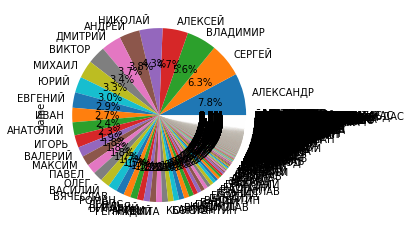

In [ ]:
males_names = males['name'].apply(lambda x: str(x))
males_names.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

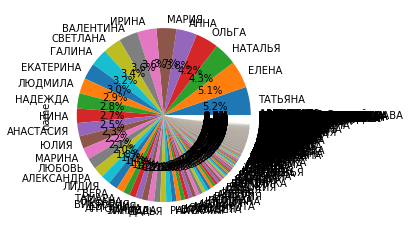

In [ ]:
females_names = females['name'].apply(lambda x: str(x))
females_names.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
males_surnames = males['surname'].apply(lambda x: str(x))
males_surnames.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
females_surnames = females['surname'].apply(lambda x: str(x))
females_surnames.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
males_patronymics = males['patronymic'].apply(lambda x: str(x))
males_patronymics.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
females_patronymics = females['patronymic'].apply(lambda x: str(x))
females_patronymics.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
# топы значений в целом соотносятся с ожиданиями
# большинство имен, фамилий и отчеств имеют характерные окончания
# стоит отдельно рассматривать каждый пол, поскольку мужчин и женщин разное количество,
# чтобы потом работать с этими данными отдельно, выделяя признаки, отличающие один пол от другого

In [ ]:
# 2. Построение признаков

In [ ]:
# Задание 2.1

In [ ]:
males_name_len = males['name'].apply(lambda x: len(x))
females_name_len = females['name'].apply(lambda x: len(x))

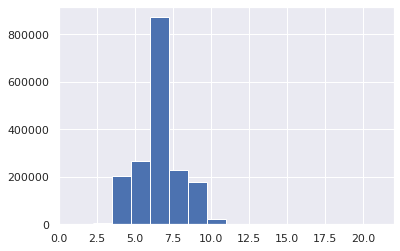

In [ ]:
# длина мужских имен

males_name_len.hist(bins=16)

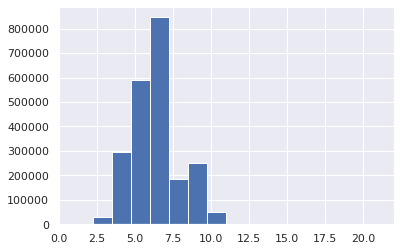

In [ ]:
# длина женских имен

females_name_len.hist(bins=16)

In [ ]:
# аналогично с фамилиями и отчествами

males_surname_len = males['surname'].apply(lambda x: len(x))
females_surname_len = females['surname'].apply(lambda x: len(x))

males_patronymic_len = males['patronymic'].apply(lambda x: len(x))
females_patronymic_len = females['patronymic'].apply(lambda x: len(x))

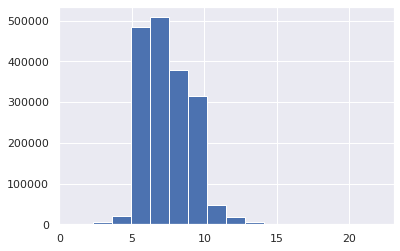

In [ ]:
males_surname_len.hist(bins = 16)

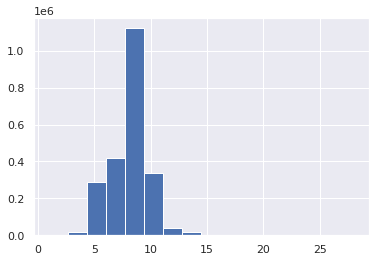

In [ ]:
females_surname_len.hist(bins = 16)

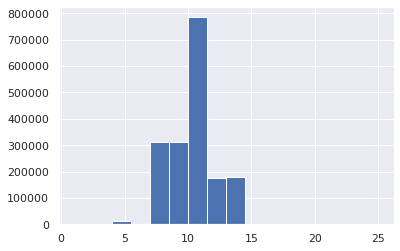

In [ ]:
males_patronymic_len.hist(bins = 16)

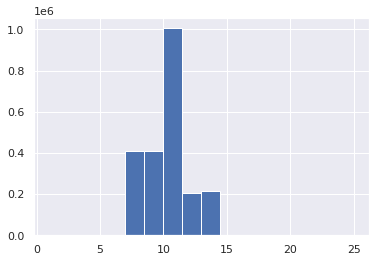

In [ ]:
females_patronymic_len.hist(bins = 16)

In [ ]:
# разница в длине имен заметна: большинство мужских имеют длину примерно 6-7, 
# а женские в большинстве 5-7, в целом женские на 1-2 символа короче
# фамилии длинее женские: большинство женских имеют длину 8-9,
# а мужских - от 5 до 8, разница примерно 2-3 символа
# отчества распределены примерно одинаково

In [ ]:
# Задание 2.2

In [ ]:
males_name_ending = males['name'].apply(lambda x: str(x)[-2:])
females_name_ending = females['name'].apply(lambda x: str(x)[-2:])

In [ ]:
males_name_ending

1          ОР
3          ЕЙ
4          РК
6          ЬЯ
9          ДР
           ..
5917163    ИС
5917164    ИЙ
5917166    ИЙ
5917168    ЕБ
5917173    ИЙ
Name: name, Length: 1782621, dtype: object

In [ ]:
females_name_ending

0          НА
2          ГА
5          НА
7          ИЯ
8          КА
           ..
5917149    ИЯ
5917153    ВА
5917155    ИЯ
5917169    НА
5917171    ИЯ
Name: name, Length: 2251339, dtype: object

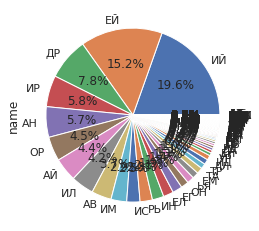

In [ ]:
males_name_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

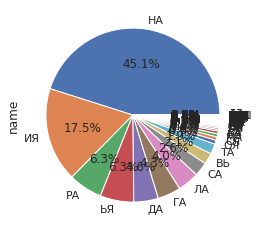

In [ ]:
females_name_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
males_surname_ending = males['surname'].apply(lambda x: str(x)[-2:])
females_surname_ending = females['surname'].apply(lambda x: str(x)[-2:])

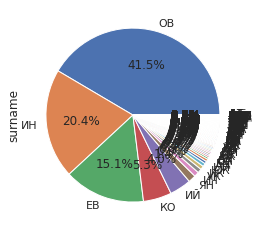

In [ ]:
males_surname_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

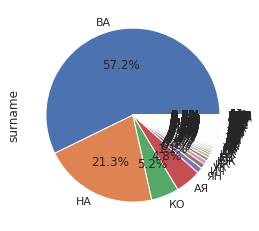

In [ ]:
females_surname_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
males_patronymic_ending = males['patronymic'].apply(lambda x: str(x)[-2:])
females_patronymic_ending = females['patronymic'].apply(lambda x: str(x)[-2:])

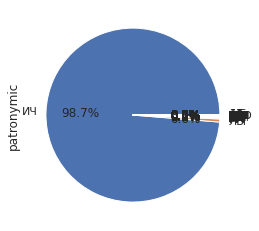

In [ ]:
males_patronymic_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

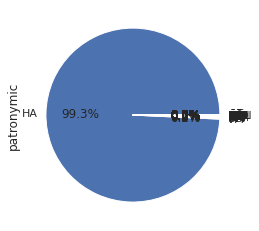

In [ ]:
females_patronymic_ending.value_counts().plot.pie( autopct='%1.1f%%', shadow=False)

plt.show()

In [ ]:
# мужские и женские имена, фамилии и отчества имеют сильные различия
# мужские имена оканчиваются на ий, ей, др, ир, ан и др., а женские на на, ия, ра, ья, да и др.
# мужские фамилии оканчиваются на ов, ин, ен, ко и др., а женские на ва, на, ко, ая и др.
# мужские отчества оканчиваются на ич, женские на на.

In [ ]:
# Задание 2.3 -> см. задание 5) (все задание отдельно, к тестовым данным не применяю)

In [ ]:
# 3. Предобработка и построение моделей

In [ ]:
# Задание 3.1

In [93]:
data1 = data

In [74]:
! pip3 install nltk

In [75]:
!pip install texthero
import texthero as hero

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 235 kB 36.0 MB/s 
     |████████████████████████████████| 749 kB 34.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [76]:
from texthero import preprocessing

In [94]:
custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_whitespace,
                   preprocessing.stem]

data1['patronymic'] = hero.clean(data1['patronymic'], pipeline = custom_pipeline)
data1['name'] = hero.clean(data1['name'], pipeline = custom_pipeline)
data1['surname'] = hero.clean(data1['surname'], pipeline = custom_pipeline)

In [95]:
#data1.head()

,Id,surname,name,patronymic,target
0,2636471,якушова,елена,сергеевна,0.0
1,165386,вабищевич,федор,петрович,1.0
2,243807,голубева,ольга,антоновна,0.0
3,232582,глазков,андрей,владимирович,1.0
4,3970023,гаврищук,марк,вадимович,1.0


In [97]:
data1['patronymic'] = data1['patronymic'].str.replace('ё','е')
data1['name'] = data1['name'].str.replace('ё','е')
data1['surname'] = data1['surname'].str.replace('ё','е')

In [98]:
data1 = data1[
data1['name'].apply(lambda x: '[a-z]' not in x) &
data1['surname'].apply(lambda x: '[a-z]' not in x) &
data1['patronymic'].apply(lambda x: '[a-z]' not in x) &
data1['name'].apply(lambda x: '[0-9]' not in x) &
data1['surname'].apply(lambda x: '[0-9]' not in x) &
data1['patronymic'].apply(lambda x: '[0-9]' not in x)
  ]

In [116]:
males1 = data1.loc[data1['target']== 1.0]
females1 = data1.loc[data1['target']== 0.0]

In [ ]:
# с дубликатами и таргетом разобрались раньше
# записи с буквами не из кириллицы не имеют смысловой нагрузки (не настоящие имена)
# и будут мешать обучению моделей

In [ ]:
# Задание 3.2

In [99]:
# датафрейм с фичами

feature_df = data1

In [ ]:
# на всякий случай еще раз удалим строки с пустыми значениями

feature_df.dropna(inplace = True)

In [82]:
nm_lst_ltts = lambda x: str(x)[-2:]
feature_df['name_last_letters'] = feature_df['name'].map(nm_lst_ltts)
feature_df['surname_last_letters'] = feature_df['surname'].map(nm_lst_ltts)
feature_df['patronymic_last_letters'] = feature_df['patronymic'].map(nm_lst_ltts)

nm_ln = lambda x: len(x)
feature_df['name_length'] = feature_df['name'].map(nm_ln)
feature_df['surname_length'] = feature_df['surname'].map(nm_ln)
feature_df['patronymic_length'] = feature_df['patronymic'].map(nm_ln)


In [ ]:
# удаление ненужных столбцов

feature_df = feature_df.drop(feature_df.columns[[1,2,3]], axis = 1)

In [ ]:
# нужный порядок столбцов

feature_df = feature_df[['Id', 'name_last_letters', 'surname_last_letters',
                         'patronymic_last_letters', 'name_length', 'surname_length',
                         'patronymic_length', 'target']]

In [ ]:
#feature_df.head()

,Id,name_last_letters,surname_last_letters,patronymic_last_letters,name_length,surname_length,patronymic_length,target
0,2636471,на,ва,на,5,7,9,0.0
1,165386,ор,ич,ич,5,9,8,1.0
2,243807,га,ва,на,5,8,9,0.0
3,232582,ей,ов,ич,6,7,12,1.0
4,3970023,рк,ук,ич,4,8,9,1.0


In [130]:
from sklearn.model_selection import train_test_split

In [ ]:
train = feature_df[['Id', 'name_last_letters',	'surname_last_letters',	'patronymic_last_letters',	'name_length',	'surname_length',	'patronymic_length']]
target = feature_df['target']

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, random_state=1337)

In [ ]:
# Задание 3.3

In [133]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml #?
from sklearn.impute import SimpleImputer

In [ ]:
# основа пайплайна

numeric_features = ["name_length", "surname_length", "patronymic_length"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["name_last_letters", "surname_last_letters", "patronymic_last_letters"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


#clf = Pipeline(
#    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
#)

In [ ]:
# отделение валидационной выборки до предобработки признаков позволяет поставить
# данные для валидации в то же положение, в котором будут тестовые данные
# (они будут обрабатываться отдельно, а не вместе с данными трейна), таким образом значение accuracy более честное
# модель обрабатывает массив данных, никак не пересекающийся с тем, на котором будут предсказания
# (например, медиана будет только на данных трейна, и т.д.)
# это означает независимость обучения на данных трена от тестовых

In [ ]:
# Задание 3.4

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import roc_auc_score

In [ ]:
# LinearRegression

In [ ]:
# линейная регрессия не поддерживает roc_auc_score, 
# поэтому для нее просто посчитаем model score
# уже по второму знаку после запятой там видно, что это самая неточная модель

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearRegression())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

model score: 0.989


In [ ]:
# LogisticRegression

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter = 1000))]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.998
accuracy = 0.997484116457743


In [ ]:
# DecisionTree

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth=4))]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.997
accuracy = 0.997043426657728


In [ ]:
# RandomForest

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(n_estimators = 100,verbose=3,n_jobs=-1, max_depth = 4))]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   15.3s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   53.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.3s finished


model score: 0.994


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.3s finished


accuracy = 0.9944354470030365


In [ ]:
# модели DecisionTree и RandomForest работают очень долго и занимают много места в памяти, если не сменить
# дефолтные параметры, например, ограничить max_depth или установить n_estimators
# (параметры для них были взяты из интернета и с семинаров)

In [ ]:
# XGBoost

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", XGBClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.998
accuracy = 0.997456278263883


In [ ]:
# LightGBM

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.998
accuracy = 0.9975541700491739


In [ ]:
# Резюме: посчитали для всех моделей model score и accuracy (кроме линейной регрессии)
# самая неэффективная модель - LinearRegression (model score: 0.989),
# самая эффективная - LGBM (accuracy = 0.9975541700491739), ее и выбираем для разметки теста
# для DecisionTree и RandomForest пришлось изменить дефолтные параметры,
# поскольку они были самыми долгими по времени работы (>50 минут)
# линейная регрессия дает общее линейное представление о взаимосвязи (и не очень долгое время работы), но не очень высокую точность
# логистическая регрессия - большее время работы, выше точность, но тоже не самую высокую
# DecisionTree и RandomForest - наглядное представление (дерево решений), но очень долгое время работы
# (точность может зависеть от глубины дерева)
# самые точные модели - XGBoost и LGBM (время работы среднее)

In [ ]:
# 4. В погоне за кагглом

In [ ]:
test_data = pd.read_csv("test.csv", encoding="utf-8", on_bad_lines='skip', 
                   na_values = {
                                "target": ["NaN"],
                                "surname": ["NaN", "-", "*", "---", "."],
                                "name": ["NaN", "-", "*", "---", "."],
                                "patronymic": ["NaN", "-", "*", "---", "."]})
#test_data.head()

,Id,surname,name,patronymic
0,1189900,ШВАЛЕВА,ОЛЬГА,ИВАНОВНА
1,4860318,БОНДАРЕНКО,АЛСУ,РИШАТОВНА
2,4244510,ОВЧИННИКОВА,ТАТЬЯНА,СЕРГЕЕВНА
3,2125017,ОРЛОВА,НЕЛИ,ИВАНОВНА
4,5814532,АНОХИНА,НИНА,ДМИТРИЕВНАХ


In [ ]:
#test_data.shape

(311431, 4)

In [ ]:
# статистика пропусков

print(pd.isnull(test_data).sum())

Id              0
surname         4
name            9
patronymic    885
dtype: int64


In [ ]:
# все пропущенные данные заменяем на "-1"

# возможные улучшения (гипотетически):
# можно было бы заменить пропущенные данные (как минимум отчества)
# самыми популярными или двумя последними буквами в зависимости от пола,
# поскольку нам важно окончание, а более 95% женских отчеств
# оканчиваются на "на", а более 95% мужских - "ич"
# для этого можно было бы составить мини-модель анализа пола для оставшихся данных
# в строке с пропусками

In [ ]:
test_data.fillna('-1', inplace = True)

In [ ]:
#test_data.head(297)

,Id,surname,name,patronymic
0,1189900,ШВАЛЕВА,ОЛЬГА,ИВАНОВНА
1,4860318,БОНДАРЕНКО,АЛСУ,РИШАТОВНА
2,4244510,ОВЧИННИКОВА,ТАТЬЯНА,СЕРГЕЕВНА
3,2125017,ОРЛОВА,НЕЛИ,ИВАНОВНА
4,5814532,АНОХИНА,НИНА,ДМИТРИЕВНАХ
...,...,...,...,...
292,706379,МАСЮК,МАРГАРИТА,ВАСИЛЬЕВНА
293,1882277,МИСАИЛОВА,ЕКАТЕРИНА,ДМИТРИЕВНА
294,4414862,ЧАБАНОВ,ВИКТОР,-1
295,4769020,ЛУКЬЯНОВ,РОМАН,АЛЕКСЕЕВИЧ


In [ ]:
custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   #preprocessing.remove_whitespace,
                   preprocessing.stem]

test_data['patronymic'] = hero.clean(test_data['patronymic'], pipeline = custom_pipeline)
test_data['name'] = hero.clean(test_data['name'], pipeline = custom_pipeline)
test_data['surname'] = hero.clean(test_data['surname'], pipeline = custom_pipeline)
#test_data.head()

,Id,surname,name,patronymic
0,1189900,швалева,ольга,ивановна
1,4860318,бондаренко,алсу,ришатовна
2,4244510,овчинникова,татьяна,сергеевна
3,2125017,орлова,нели,ивановна
4,5814532,анохина,нина,дмитриевнах


In [ ]:
test_data['patronymic'] = test_data['patronymic'].str.replace('ё','е')
test_data['name'] = test_data['name'].str.replace('ё','е')
test_data['surname'] = test_data['surname'].str.replace('ё','е')

In [ ]:
# поскольку строк с не кириллическими символами (в осн. цифры и латиница) нет, то 
# опустим обработку, связанную с ними

In [ ]:
# готовим датафрейм с фичами

fea = test_data

In [ ]:
nm_lst_ltts1 = lambda x: str(x)[-2:]
fea['name_last_letters'] = fea['name'].map(nm_lst_ltts1)
fea['surname_last_letters'] = fea['surname'].map(nm_lst_ltts1)
fea['patronymic_last_letters'] = fea['patronymic'].map(nm_lst_ltts1)

nm_ln1 = lambda x: len(x)
fea['name_length'] = fea['name'].map(nm_ln1)
fea['surname_length'] = fea['surname'].map(nm_ln1)
fea['patronymic_length'] = fea['patronymic'].map(nm_ln1)


In [ ]:
fea = fea.drop(fea.columns[[1,2,3]], axis = 1)

In [ ]:
fea = fea[['Id', 'name_last_letters', 'surname_last_letters',
                         'patronymic_last_letters', 'name_length', 'surname_length',
                         'patronymic_length']]

In [ ]:
test_train = fea[['Id', 'name_last_letters',	'surname_last_letters',	'patronymic_last_letters',	'name_length',	'surname_length',	'patronymic_length']]

In [ ]:
# LGBM

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

target_pred = clf.predict(test_train)
print(target_pred)

model score: 0.998
[0. 0. 0. ... 0. 0. 1.]


In [ ]:
# создаем submission

In [ ]:
fea['target'] = target_pred
fea1 = fea.drop(fea.columns[[1,2,3,4,5,6]], axis = 1)
fea1.to_csv('submission.csv', index=False)

,Id,target
0,1189900,0.0
1,4860318,0.0
2,4244510,0.0
3,2125017,0.0
4,5814532,0.0
...,...,...
311426,3458528,0.0
311427,1700965,0.0
311428,5022755,0.0
311429,1127718,0.0


In [ ]:
#fea1.shape

(311431, 2)

In [ ]:
# 5. Ресерч

In [ ]:
# фича1: процент(доля) гласных в именах/фамилиях
# гипотеза - в женских именах/фамилиях больше доля гласных

# фича2: количество мягких знаков в именах
# гипотеза - в женских именах мягкие знаки встречаются чаще

# фича3*: можно было бы еще посмотреть на типичные части азиатских отчеств
# типа кызы (жен) и оглы/оглу(муж), но их мало и, как правило, там все понятно по имени и фамилии

In [ ]:
# фича1

In [34]:
global vowels
vowels = set('АЕЁИОУЫЭЮЯаеёиоуыэюя')


def num_vowels(y):
    counter = 0
    for i in range(len(y)):
        if y[i] in vowels:
            counter += 1
    return counter

In [109]:
#vowels_num = lambda x: num_vowels(str(x))
vowels_persent = lambda x: num_vowels(str(x))/len(str(x))

In [ ]:
# для имен

In [110]:
males_vowels_per_name = males['name'].apply(vowels_persent)
females_vowels_per_name = females['name'].apply(vowels_persent)

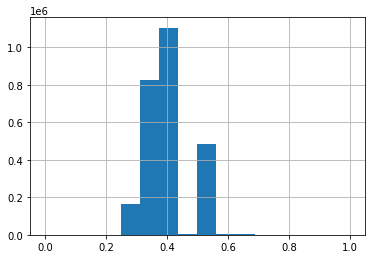

In [54]:
males_vowels_per_name.hist(bins=16)

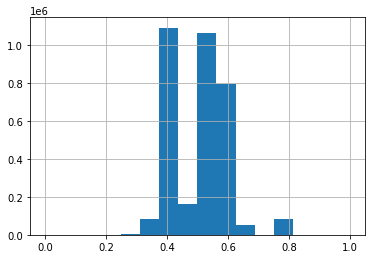

In [55]:
females_vowels_per_name.hist(bins=16)

In [ ]:
# для фамилий

In [67]:
males_vowels_per_sur = males['surname'].apply(vowels_persent)
females_vowels_per_sur = females['surname'].apply(vowels_persent)

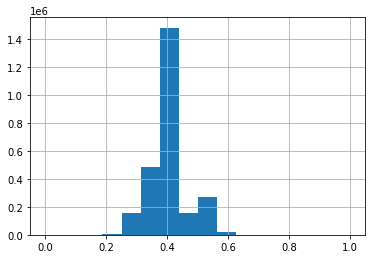

In [68]:
males_vowels_per_sur.hist(bins=16)

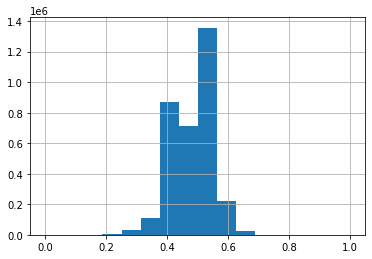

In [69]:
females_vowels_per_sur.hist(bins=16)

In [ ]:
# вроде гипотеза работает, в женских именах и фамилиях % гласных 0.4-0.6,
# тогда как в мужских 0.3-0.4
# на отчества смотреть бесполезно, потому что они одинаковые, кроме окончания,
# окончания рассматривались раньше

In [ ]:
# добавим фичу к обучающим данным

In [122]:
exp_feature_df = data1

In [ ]:
exp_feature_df.dropna(inplace = True)

In [101]:
nm_lst_ltts = lambda x: str(x)[-2:]
exp_feature_df['name_last_letters'] = exp_feature_df['name'].map(nm_lst_ltts)
exp_feature_df['surname_last_letters'] = exp_feature_df['surname'].map(nm_lst_ltts)
exp_feature_df['patronymic_last_letters'] = exp_feature_df['patronymic'].map(nm_lst_ltts)

nm_ln = lambda x: len(str(x))
exp_feature_df['name_length'] = exp_feature_df['name'].map(nm_ln)
exp_feature_df['surname_length'] = exp_feature_df['surname'].map(nm_ln)
exp_feature_df['patronymic_length'] = exp_feature_df['patronymic'].map(nm_ln)

In [125]:
vowels_persent = lambda x: num_vowels(str(x))/len(str(x))
exp_feature_df['name_vowels_percent'] = exp_feature_df['name'].map(vowels_persent)
exp_feature_df['surname_vowels_percent'] = exp_feature_df['surname'].map(vowels_persent)

In [127]:
exp_feature_df = exp_feature_df.drop(exp_feature_df.columns[[1,2,3]], axis = 1)

In [128]:
exp_feature_df = exp_feature_df[['Id', 'name_last_letters', 'surname_last_letters',
                         'patronymic_last_letters', 'name_length', 'surname_length',
                         'patronymic_length', 'name_vowels_percent', 'surname_vowels_percent', 'target']]

In [129]:
#exp_feature_df

,Id,name_last_letters,surname_last_letters,patronymic_last_letters,name_length,surname_length,patronymic_length,name_vowels_percent,surname_vowels_percent,target
0,2636471,на,ва,на,5,7,9,0.600000,0.571429,0.0
1,165386,ор,ич,ич,5,9,8,0.400000,0.444444,1.0
2,243807,га,ва,на,5,8,9,0.400000,0.500000,0.0
3,232582,ей,ов,ич,6,7,12,0.333333,0.285714,1.0
4,3970023,рк,ук,ич,4,8,9,0.250000,0.375000,1.0
...,...,...,...,...,...,...,...,...,...,...
5917166,962825,ий,ов,ич,8,7,9,0.375000,0.428571,1.0
5917168,3499092,еб,ев,ич,4,7,9,0.250000,0.428571,1.0
5917169,4354130,на,ва,на,5,7,10,0.600000,0.428571,0.0
5917171,3299674,ия,на,на,4,8,10,0.750000,0.500000,0.0


In [131]:
train = exp_feature_df[['Id', 'name_last_letters',	'surname_last_letters',	'patronymic_last_letters',	'name_length',	'surname_length',	'patronymic_length','name_vowels_percent', 'surname_vowels_percent']]
target = exp_feature_df['target']

In [132]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, random_state=1337)

In [135]:
numeric_features = ["name_length", "surname_length", "patronymic_length", "name_vowels_percent", "surname_vowels_percent"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["name_last_letters", "surname_last_letters", "patronymic_last_letters"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [ ]:
# беру модель LGBM, поскольку она самая точная

In [137]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.998
accuracy = 0.997609723689953


In [ ]:
# можно заметить, что accuracy немного повысилась (было accuracy = 0.9975541700491739)
# фича работает!

In [ ]:
# фича2

In [62]:
global uou
uou = set('Ьь')

def num_uou(z):
    c = 0
    for i in range(len(z)):
        if z[i] in uou:
            c += 1
    return c

In [63]:
uou_num = lambda x: num_uou(str(x))

In [64]:
males_uou = males['name'].apply(uou_num)
females_uou = females['name'].apply(uou_num)

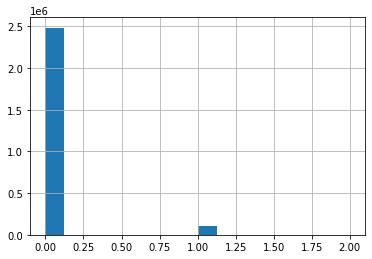

In [65]:
males_uou.hist(bins=16)

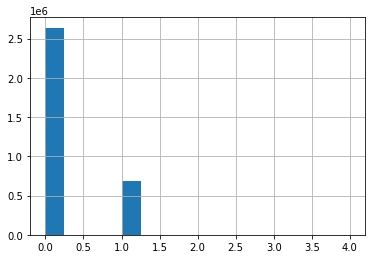

In [66]:
females_uou.hist(bins=16)

In [ ]:
# в женских именах действительно чаще встречаются мягкие знаки, однако непонятно, насколько значим признак

In [ ]:
# добавим фичу к обучающим данным

In [138]:
exp_feature_df1 = data1

In [140]:
nm_lst_ltts = lambda x: str(x)[-2:]
exp_feature_df1['name_last_letters'] = exp_feature_df1['name'].map(nm_lst_ltts)
exp_feature_df1['surname_last_letters'] = exp_feature_df1['surname'].map(nm_lst_ltts)
exp_feature_df1['patronymic_last_letters'] = exp_feature_df1['patronymic'].map(nm_lst_ltts)

nm_ln = lambda x: len(str(x))
exp_feature_df1['name_length'] = exp_feature_df1['name'].map(nm_ln)
exp_feature_df1['surname_length'] = exp_feature_df1['surname'].map(nm_ln)
exp_feature_df1['patronymic_length'] = exp_feature_df1['patronymic'].map(nm_ln)

In [141]:
uou_num = lambda x: num_uou(str(x))
exp_feature_df1['name_ь'] = exp_feature_df1['name'].map(uou_num)

In [ ]:
exp_feature_df1 = exp_feature_df1.drop(exp_feature_df1.columns[[1,2,3]], axis = 1)

In [143]:
exp_feature_df1 = exp_feature_df1[['Id', 'name_last_letters', 'surname_last_letters',
                         'patronymic_last_letters', 'name_length', 'surname_length',
                         'patronymic_length', 'name_ь', 'target']]

In [144]:
#exp_feature_df1

,Id,name_last_letters,surname_last_letters,patronymic_last_letters,name_length,surname_length,patronymic_length,name_ь,target
0,2636471,на,ва,на,5,7,9,0,0.0
1,165386,ор,ич,ич,5,9,8,0,1.0
2,243807,га,ва,на,5,8,9,1,0.0
3,232582,ей,ов,ич,6,7,12,0,1.0
4,3970023,рк,ук,ич,4,8,9,0,1.0
...,...,...,...,...,...,...,...,...,...
5917166,962825,ий,ов,ич,8,7,9,0,1.0
5917168,3499092,еб,ев,ич,4,7,9,0,1.0
5917169,4354130,на,ва,на,5,7,10,0,0.0
5917171,3299674,ия,на,на,4,8,10,0,0.0


In [146]:
train = exp_feature_df1[['Id', 'name_last_letters',	'surname_last_letters',	'patronymic_last_letters',	'name_length',	'surname_length',	'patronymic_length','name_ь']]
target = exp_feature_df1['target']

In [147]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, random_state=1337)

In [150]:
numeric_features = ["name_length", "surname_length", "patronymic_length", "name_ь"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ["name_last_letters", "surname_last_letters", "patronymic_last_letters"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [ ]:
# тоже LGBM

In [151]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_valid, y_valid))

y_pred = clf.predict(X_valid)

# качество модели
accuracy = roc_auc_score(y_pred, y_valid)
print("accuracy =", accuracy)

model score: 0.998
accuracy = 0.9976059452902802


In [ ]:
# фича тоже дала повышение точности (было accuracy = 0.9975541700491739), хотя меньше, чем первая
# но фича работает!